In [1]:
# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tempfile import TemporaryDirectory

import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18, resnet50, resnet34, resnet101
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


In [330]:
# CIFAR 10 dataset

# Transformations
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224))
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomCrop(32,padding=4,padding_mode="reflect")
    ]
)

# Train data
train_set = torchvision.datasets.OxfordIIITPet(
    root="./data", split='trainval', download=True, transform=train_transform
)
# Train loader
train_loader = DataLoader(train_set, shuffle=False, num_workers=2, batch_size=200)

# Test data
test_set = torchvision.datasets.OxfordIIITPet(
    root="./data", split='test', download=True, transform=test_transform
)
# Test loader
test_loader = DataLoader(test_set, shuffle=False, num_workers=2, batch_size=200
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])


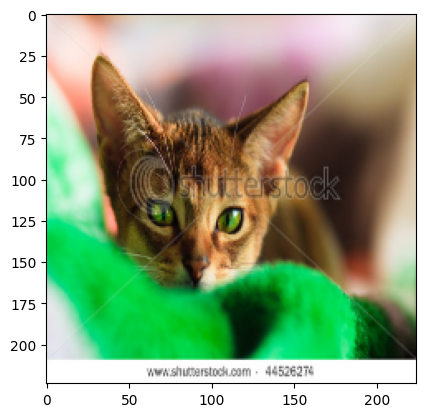

In [331]:
images, labels = next(iter(train_loader))
plt.imshow(images[1].permute(1, 2, 0))
print(labels)

In [413]:
cat_labels = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]

In [414]:
len(cat_labels)

12

In [366]:
labels_set = [train_set[i][1] for i in range(len(train_set))]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [367]:
labels_set = np.array(labels_set)

In [483]:
# Indencies of cars
car_indxs = np.where(np.array(labels_set) == 14)[0]

In [484]:
cars_set = torch.utils.data.Subset(train_set, car_indxs)
cars_set[0]

(tensor([[[0.7538, 0.7063, 0.7188,  ..., 0.2241, 0.2450, 0.3228],
          [0.7602, 0.7383, 0.7685,  ..., 0.3104, 0.3701, 0.3586],
          [0.7641, 0.7704, 0.7870,  ..., 0.3084, 0.4712, 0.3315],
          ...,
          [0.4682, 0.3246, 0.5142,  ..., 0.5778, 0.4183, 0.4211],
          [0.5798, 0.3696, 0.5302,  ..., 0.6151, 0.6373, 0.4521],
          [0.4762, 0.2791, 0.4787,  ..., 0.5053, 0.6362, 0.4589]],
 
         [[0.7824, 0.7558, 0.7605,  ..., 0.3202, 0.2944, 0.3791],
          [0.8060, 0.7896, 0.8095,  ..., 0.3650, 0.4094, 0.4434],
          [0.8105, 0.8258, 0.8309,  ..., 0.3766, 0.5315, 0.4313],
          ...,
          [0.5716, 0.5064, 0.6018,  ..., 0.6720, 0.4847, 0.4568],
          [0.6506, 0.4791, 0.5640,  ..., 0.7083, 0.7211, 0.4843],
          [0.6380, 0.4067, 0.5846,  ..., 0.6024, 0.6945, 0.4859]],
 
         [[0.4881, 0.4743, 0.4866,  ..., 0.1531, 0.1592, 0.2458],
          [0.5043, 0.5074, 0.5160,  ..., 0.1703, 0.2393, 0.2508],
          [0.5183, 0.5220, 0.5262,  ...,

In [485]:
cars_loader = torch.utils.data.DataLoader(
    cars_set, batch_size=20, shuffle=False, num_workers=2
)

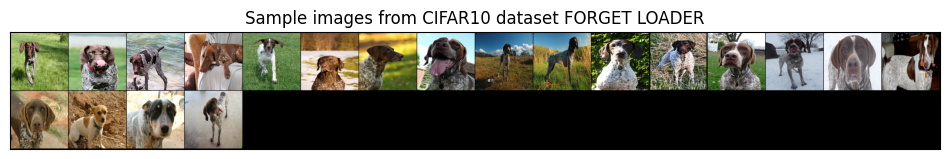

In [486]:

images, labels = next(iter(cars_loader))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset FORGET LOADER")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

In [ ]:
5